In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

In [2]:
style.use('ggplot')

# Experiment change share of chartists. 

In [9]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

Fix the learning ability at 0.0

In [21]:
params['average_learning_ability'] = 0.0
params['ticks'] = 500

In [11]:
NRUNS = 3

Increment the share of chartists from 0.0 to 100

In [27]:
share_chartists = [x / 100.0 for x in range(5, 105, 5)]

In [28]:
Experiments = len(share_chartists)

## Run model and update share chartists every time

In [30]:
trdrs = []
orbs = []
for exp in range(Experiments):
    params['strat_share_chartists'] = share_chartists[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  0
Start of si

In [32]:
full_share_chartists = []
for exp in range(Experiments):
    for seed in range(NRUNS):
        full_share_chartists.append(share_chartists[exp])

Structure the data

In [34]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [59]:
# store simulated stylized facts
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(
    orbs, burn_in_period=100)

obs = len(mc_fundamentals[0])
r0 = 0.01 + 1.8 / np.sqrt(obs)
swindow0 = int(math.floor(r0 * obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12 * yr + swindow0 - 1
nboot = 99

perc_bubble_occur = []

for idx, col in enumerate(mc_returns):
    pds = pd.Series(mc_prices[idx][:-1] / mc_fundamentals[idx])

    obs = len(pds)
    dim = obs - swindow0 + 1

    bsadfs = PSY(pds, swindow0, IC, adflag)
    quantilesBsadf = cvPSYwmboot(pds, swindow0, IC, adflag, Tb, nboot)
    monitorDates = pds.iloc[swindow0 - 1:obs].index
    quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
    ind95 = (bsadfs.T[0] > quantile95[1,])
    periods = monitorDates[ind95]

    if True in ind95:
        bubbly_dates = find_sequences_ints(periods, monitorDates)
        perc_bubble_occur.append(len(periods) / float(len(monitorDates)))
    else: 
        perc_bubble_occur.append(0.0)

In [62]:
data = pd.DataFrame({'gini': np.log(ginis[:]), 'palma': np.log(palmas[:]), 'twtw': np.log(twtws[:]), 'pd_vol': price_to_div_stdev[:],
                     'share_chartists': np.log(full_share_chartists[:]), 'perc_b_occur': perc_bubble_occur,
                     'lin_share_chartists': full_share_chartists[:], 'asset_price_infl': asset_price_inflation[:]})
data['const'] = 1

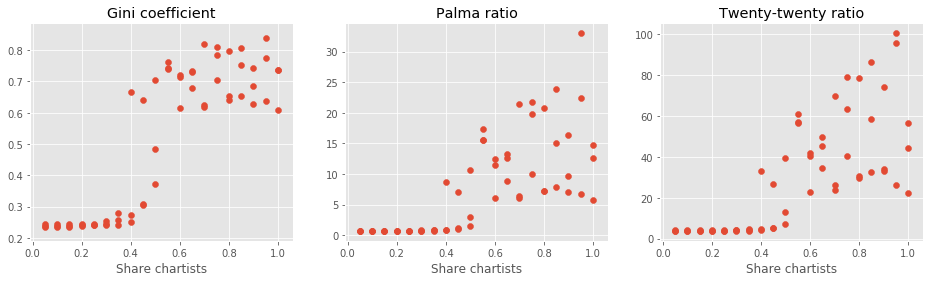

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

# ax1.scatter(range(len(ginis)), ginis)
# ax2.scatter(range(len(palmas)), palmas)
# ax3.scatter(range(len(twtws)), twtws)

ax1.scatter(data['lin_share_chartists'], ginis)
ax2.scatter(data['lin_share_chartists'], palmas)
ax3.scatter(data['lin_share_chartists'], twtws)
#ax2.scatter(range(len(palmas)), palmas)
#ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Share chartists')

fig.savefig('share_chartists_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

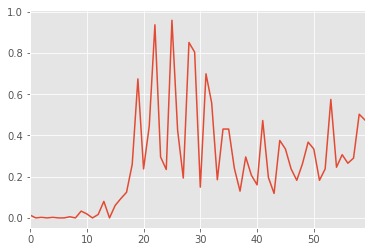

In [60]:
pd.Series(perc_bubble_occur).plot()

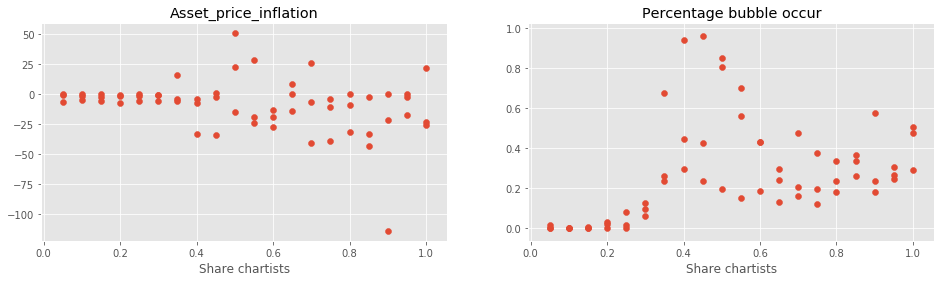

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(data['lin_share_chartists'], asset_price_inflation)
ax2.scatter(data['lin_share_chartists'], perc_bubble_occur)


ax1.set_title('Asset_price_inflation')
ax2.set_title('Percentage bubble occur')

for ax in [ax1, ax2]:
    ax.set_xlabel('Share chartists')
    
fig.savefig('share_chartists_prices_bubbles.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Regression


In [65]:
gini_res = sm.OLS(endog=data['gini'], exog=data[['const', 'share_chartists']], missing='drop').fit()
palma_res = sm.OLS(endog=data['palma'], exog=data[['const', 'share_chartists']], missing='drop').fit()
twtw_res = sm.OLS(endog=data['twtw'], exog=data[['const', 'share_chartists']], missing='drop').fit()
asset_p_inf_res = sm.OLS(endog=data['asset_price_infl'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
pd_stdev_res = sm.OLS(endog=data['pd_vol'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
perc_bubble_res = sm.OLS(endog=data['perc_b_occur'], exog=data[['const', 'share_chartists']], missing='drop').fit()

In [66]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res, asset_p_inf_res, perc_bubble_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20', 'Asset-price inflation', 'Bubble occur'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_chartists'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                                               Table - OLS Regressions
                           Gini              Palma              20-20        Asset-price inflation     Bubble occur   
----------------------------------------------------------------------------------------------------------------------
const               -0.3234***         2.4952***          3.8193***          3.0047                0.4024***          
                    (0.0572)           (0.1623)           (0.1442)           (5.7217)              (0.0416)           
share_chartists     0.5383***          1.3785***          1.2187***                                0.1503***          
                    (0.0483)           (0.1372)           (0.1219)                                 (0.0352)           
lin_share_chartists                                                          -21.9101**                               
                                                                             (9.5527)           